# Computer Vision (CV2022): Assignment 7

### - Avirup Das (MDS202013)


In [ ]:
# Installing contributor version of OpenCV for SIFT algorithm
import sys
if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())
    subprocess.call("wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/left.jpg".split())
    subprocess.call("wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/right.jpg".split())

import numpy as np
import cv2, math
from skimage import io
from skimage.util import img_as_float, img_as_ubyte
from skimage.segmentation import mark_boundaries, slic, watershed
from skimage.filters import rank
from skimage.morphology import disk
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
# Downloading images
!rm *.zip *.jpg *.png *.jpeg
!gdown 1U3428bmizr5sjUh5NMB3X0001YsEynlO
!unzip assgn7.zip

rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.png': No such file or directory
rm: cannot remove '*.jpeg': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1U3428bmizr5sjUh5NMB3X0001YsEynlO
To: /content/assgn7.zip
100% 2.52M/2.52M [00:00<00:00, 205MB/s]
Archive:  assgn7.zip
  inflating: fingerprint3.png        
  inflating: fingerprint4.png        
  inflating: fingerprint5.png        
  inflating: market.jpg              
  inflating: Pisa.jpg                
  inflating: panda.jpeg              
  inflating: hawamahal1.jpg          
  inflating: hawamahal2.jpg          
  inflating: Colors.png              


### Helper functions

In [ ]:
# Display Subplots
def disp_subplots(image, shape, titles, sup_title, axes, figsize, cmap=None):
  fig, ax = plt.subplots(shape[0], shape[1], figsize=figsize)
  try:
    ax = ax.ravel()
  except:
    pass
    
  for i in range(len(image)):
    if cmap is None:
      ax[i].imshow(image[i])
    else:
      ax[i].imshow(image[i], cmap=cmap)

    if axes[i] is None:
      ax[i].set_xticks([])
      ax[i].set_yticks([])

    if titles[i] is not None:
      ax[i].set_title(titles[i])

  if sup_title is not None:
    fig.suptitle(sup_title, fontsize=18)
  plt.show()

# Erosion and Dilation
def ero_dil(img):
  images, titles = [], []
  for i in range(2):
    # Original image
    images.append(img[i])
    titles.append(f'Original: fingerprint{i+3}.png')
    # Thresholded binary image
    _, img_bin = cv2.threshold(img[i], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    images.append(img_bin)
    titles.append('Thresholded binary image')
    # erosion
    erosion = cv2.erode(img_bin, np.ones((5,5)), iterations = 1)
    images.append(erosion)
    titles.append('Erosion')
    # dilation
    dilation = cv2.dilate(img_bin, np.ones((5,5)), iterations = 1)
    images.append(dilation)
    titles.append('Dilation')

  # Displaying results
  disp_subplots(images, (2,4), titles, 'Results on Erosion and Dilation', [None]*8,
                (20, 8), cmap='gray')

# Opening and Closing
def open_close(img, kernel_type='round'):
  images, titles = [], []
  for i in range(2):
    # Original image
    images.append(img[i])
    if i==0:
      titles.extend(['Original Image', 'Thresholded Binary Image', 'Opening', 'Closing'])
    else:
      titles.extend(['Complemented Image', 'Thresholded Binary Image Complemented',
                     'Opening Complemented', 'Closing Complemented'])
    # Thresholded binary image
    _, img_bin = cv2.threshold(img[i], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    images.append(img_bin)
    # Opening and Closing
    if kernel_type=='round':
      kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    else:
      kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    opening = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel)
    images.extend([opening, closing])

  # Displaying results
  disp_subplots(images, (2,4), titles, f'Results on Opening and Closing: {kernel_type} kernel',
                [None]*8, (20, 8), cmap='gray')
  
# K-mean segmentation
def k_means(img, img_name):
  Z = np.float32(img.reshape((-1,3)))
  # defining criterion, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  Ks, seg_img = [2, 3, 4, 5, 7, 8, 10, 11, 12, 15, 20, 25, 30, 40, 50], {}
  images, titles = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)], [img_name]
  for k in Ks:
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Converting back into uint8 to make original image
    center = np.uint8(center)
    seg_img[k] = center[label.flatten()].reshape((img.shape))
    images.append(cv2.cvtColor(seg_img[k], cv2.COLOR_BGR2RGB))
    titles.append(f'K = {k}')
  
  # Displaying results
  disp_subplots(images, (4,4), titles, f'K-means segmentation on {img_name}', [None]*16,
                (20, 15))

# Superpixel algorithm on various segments
def sup_pix(img, img_name, pix):
  # Converting image to floating data-type
  img = img_as_float(img)
  images, titles = [], []

  # looping over no. of segments
  for seg in pix:
    # apply SLIC and extract (approximately) the supplied number of segments
    segments = slic(img, n_segments = seg, sigma = 5, start_label = 1)
    images.append(mark_boundaries(img, segments))
    titles.append(f'No. of superpixels: {seg}')

  # Displaying results
  disp_subplots(images, (3,3), titles,
                f'Comparison of superpixel on {img_name} with different superpixel segments',
                [None]*9, (18, 12))

# Apply watershed algorithm for segmentation
def water_shed(img_name):
  # Reading image
  img = img_as_ubyte(cv2.imread(img_name, 0))
  # Denoising image
  den = rank.median(img, disk(2))
  '''
   find continuous region (low gradient - where less than 10 for this image) --> markers
   disk(5) is used here to get a more smooth image
  '''
  markers = rank.gradient(den, disk(5)) < 10
  markers = ndi.label(markers)[0]

  # local gradient (disk(2) is used to keep edges thin)
  grad = rank.gradient(den, disk(2))

  # process the watershed
  labels = watershed(grad, markers)

  # Displaying results
  fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize= (15, 15), sharex= True, sharey= True)
  ax[0].imshow(io.imread(img_name), cmap= plt.cm.gray)
  ax[0].set_title(f"Original: {img_name}")
  ax[1].imshow(img, cmap= plt.cm.gray)
  ax[1].imshow(labels, cmap= plt.cm.nipy_spectral, alpha= 0.5)
  ax[1].set_title("Segmented")
  for i in ax:
    i.axis('off')
  fig.tight_layout()
  plt.show()

# SIFT algorithm
def sift(img1, img2, matchings=50):
  # Reading images
  img1 = cv2.cvtColor(cv2.imread(img1), cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(cv2.imread(img2), cv2.COLOR_BGR2RGB)
  # Getting grayscale images
  img11 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img22 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  # SIFT
  sift = cv2.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(img11, None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(img22, None)

  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
  matches = bf.match(descriptors_1,descriptors_2)
  matches = sorted(matches, key = lambda x:x.distance)

  # Drawing the matches
  matched_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2,
                                matches[:matchings], img22, flags=2)
  
  # Displaying results
  fig = plt.figure(figsize = (15,10))
  plt.imshow(matched_img)
  plt.xticks([]), plt.yticks([])
  plt.title(f"SIFT with {matchings} matches")
  plt.show()

## Question 2

### Part a: Erosion and Dilation

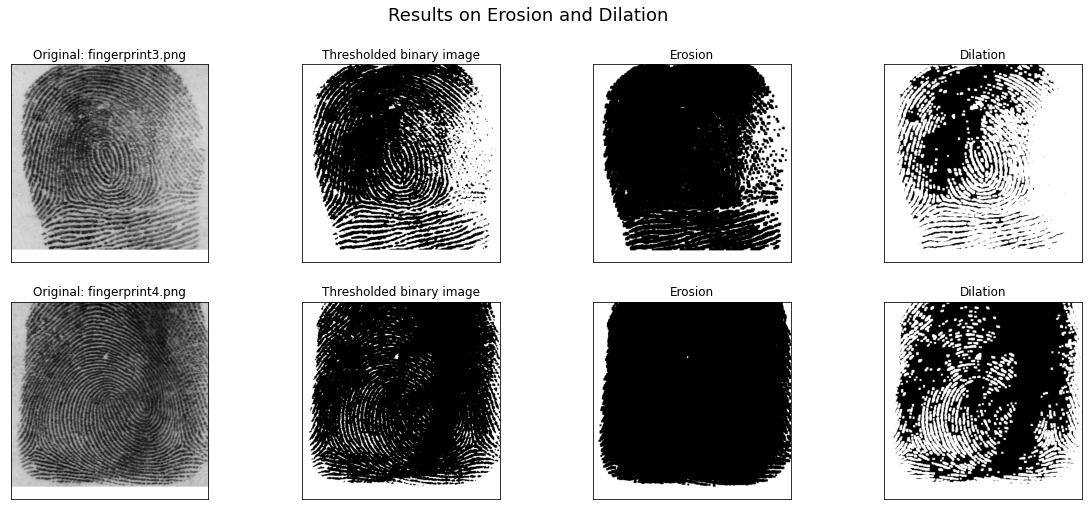

In [ ]:
# Reading images fingerprint3 and fingerprint4
img = [cv2.imread('fingerprint3.png', 0), cv2.imread('fingerprint4.png', 0)]

ero_dil(img)

### Part b: Opening and Closing

#### Round Kernel

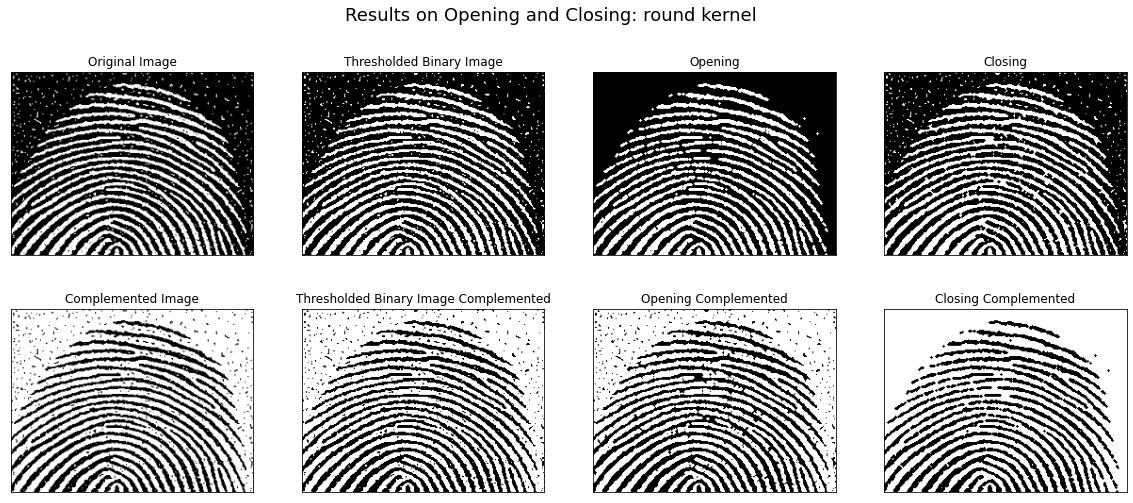

In [ ]:
# Reading fingerprint5 and creating its complement
img = [cv2.imread('fingerprint5.png',0)]
img.append(255-img[0])

open_close(img, 'round')

#### Box Kernel

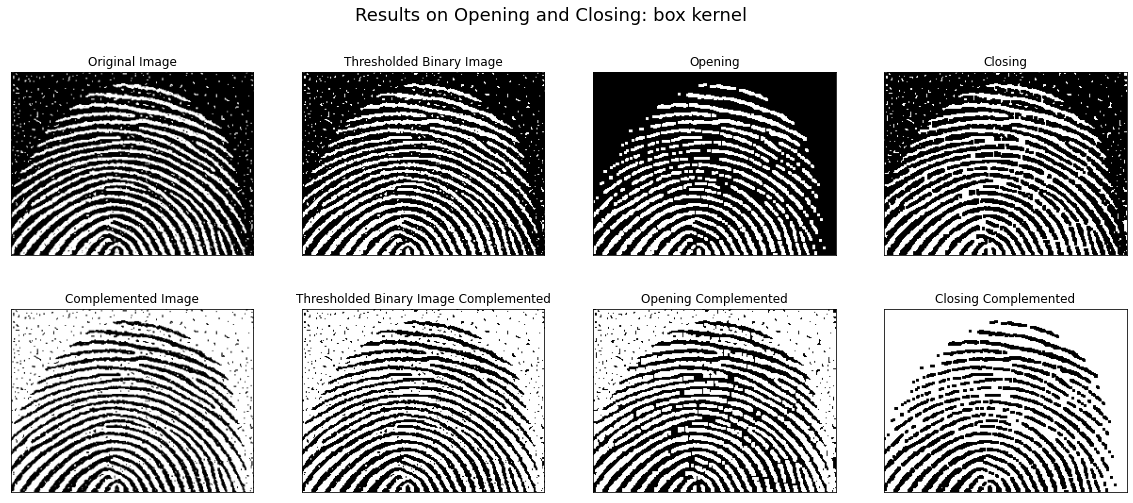

In [ ]:
open_close(img, 'box')

### Part c: K-means clustering

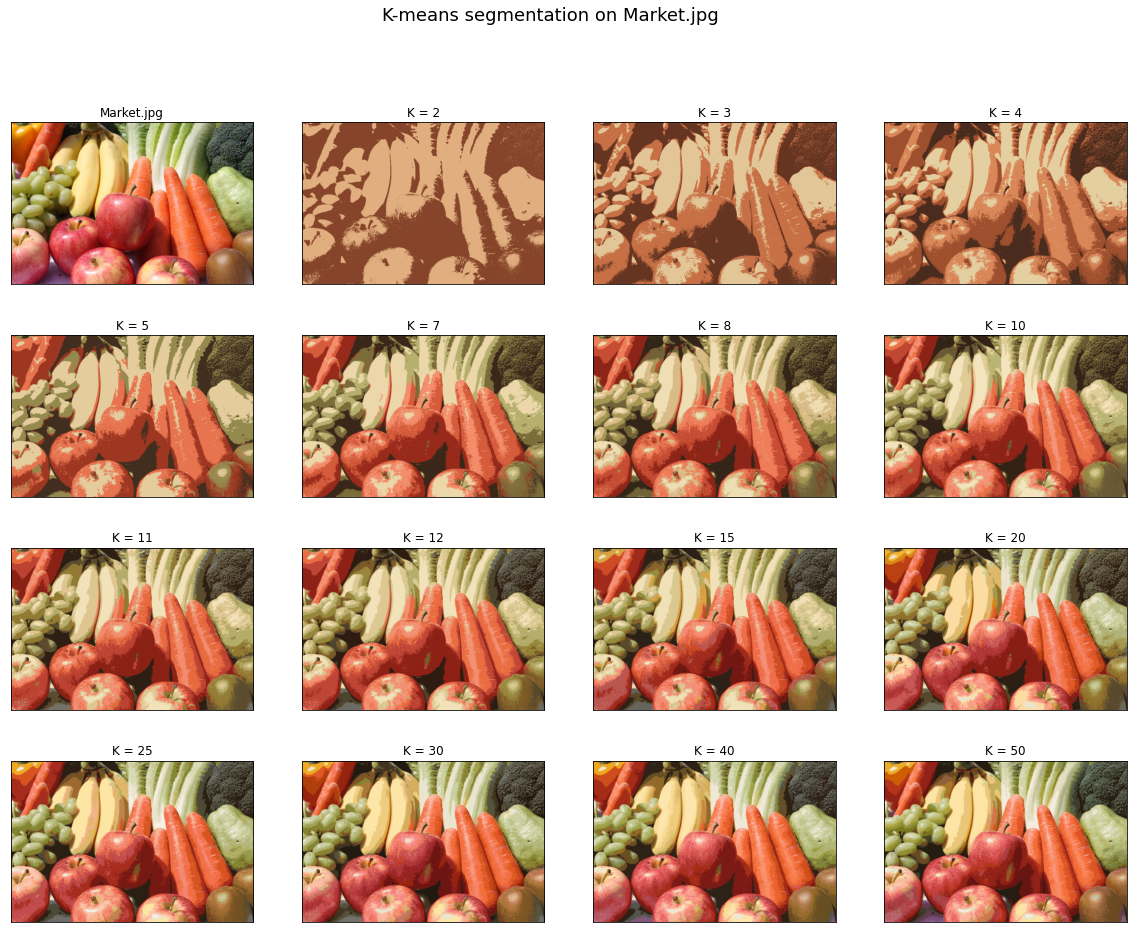

In [ ]:
img = cv2.imread('market.jpg')
k_means(img, 'Market.jpg')

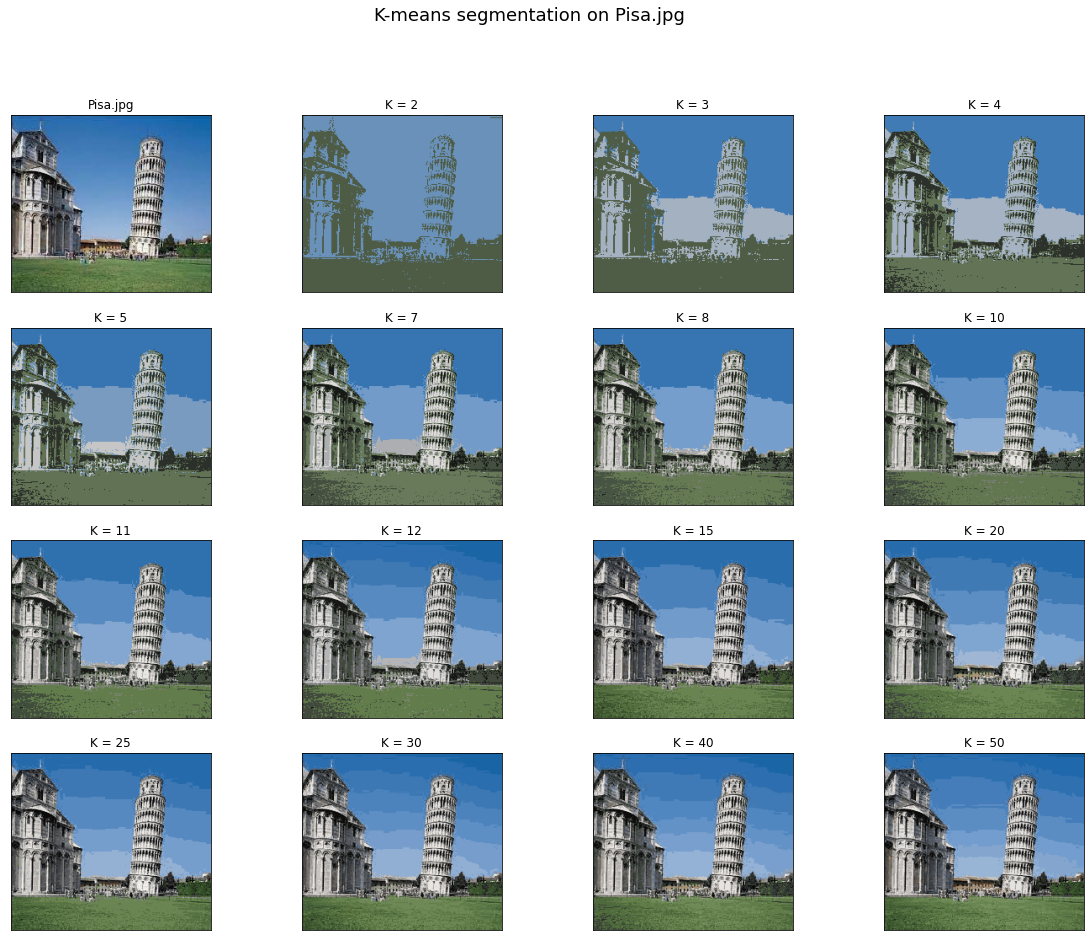

In [ ]:
img = cv2.imread('Pisa.jpg')
k_means(img, 'Pisa.jpg')

From the above results for both the images, i.e., 'pisa.jpg' and 'market.jpg', we observed that the segmentation improves with the increase in binning-size since the K-means algorithm can classify more classes (here, cluster of similar colors).

We also observe that the resulting image gets closer to the original image as we increase the number of bins. This is expected since increasing the bin-size leads to the pixel values of the original image getting classified into larger number of clusters resulting in almost similar distribution of the original image.

### Part d: Superpixel

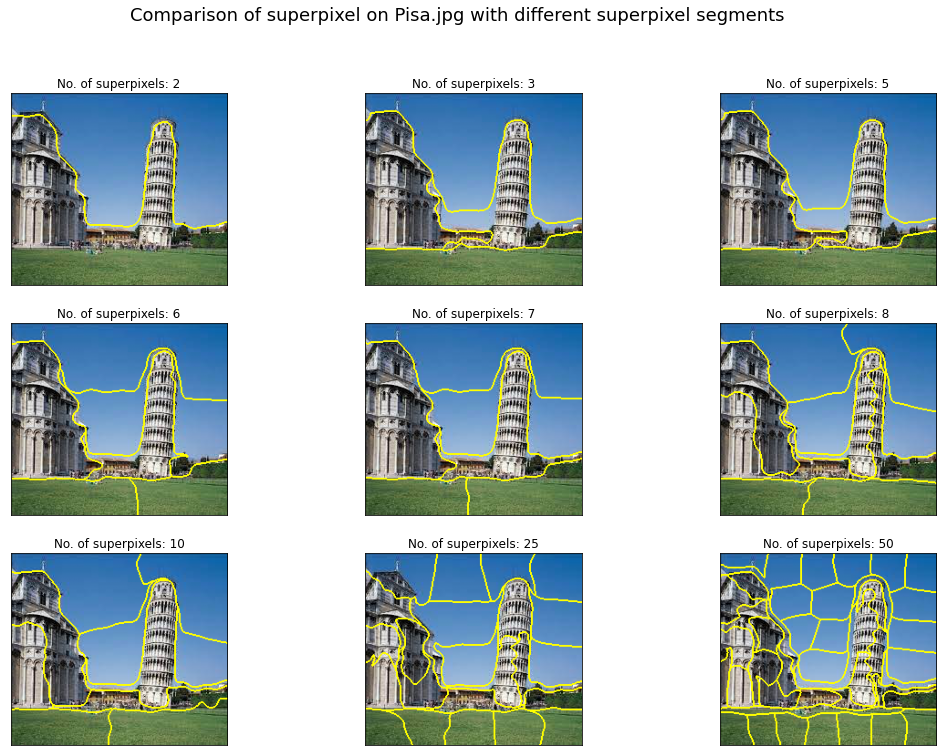

In [ ]:
# Superpixel on Pisa.jpg
img = io.imread('Pisa.jpg')
sup_pix(img, 'Pisa.jpg', [2, 3, 5, 6, 7, 8, 10, 25, 50])

From the above results we observe that as the number of superpixels increase, the image gets more segmented according to the pixel values, as expected. When the number of segments is 6, the image gets more or less correctly segmented marking boundaries around the different color regions of the tower, the building, the sky (seperated by various shades), the field and even the trees and the houses in the backgroud. On increasing the number of superpixels the image starts to get over-segmented, thus gradually making the result less meaningful which is clearly observable for cases 25 and 50, where interpretation of segmentation is lost.

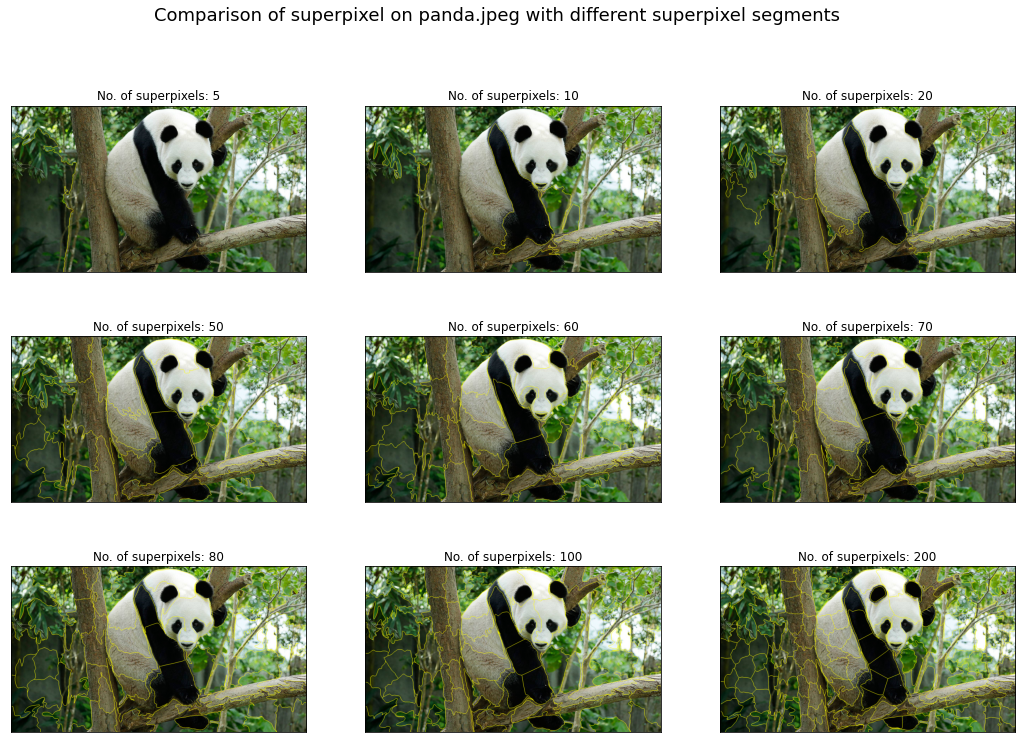

In [ ]:
# Superpixel on panda.jpeg
img = io.imread('panda.jpeg')
sup_pix(img, 'panda.jpeg', [5, 10, 20, 50, 60, 70, 80, 100, 200])

From the above results we observe the same phenomenon, i.e., the image gets over-segmented as we increase the pixel values. For this image however, the optimum number would be around 60 where the image gets correctly segmented, marking boundaries around the different shades of the panda, the tree and its leaves. We lose interpretability like in the previous case, when we go beyond 100 super-pixels.

### Part e: Watershed

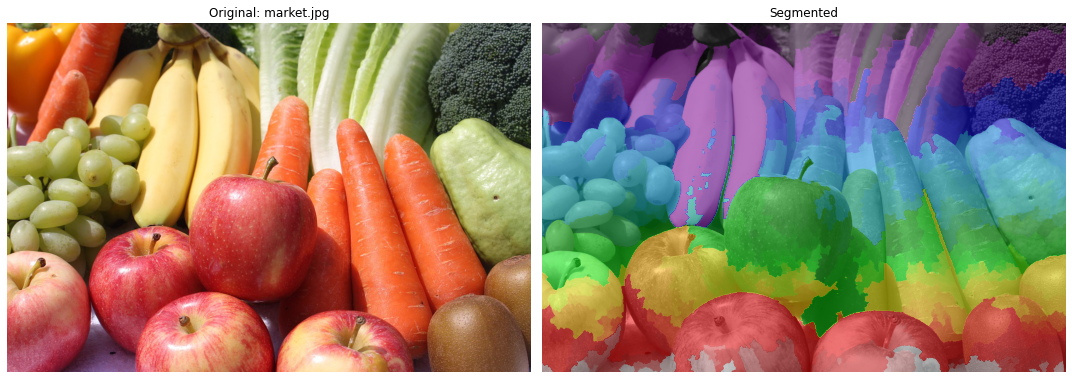

In [ ]:
water_shed('market.jpg')

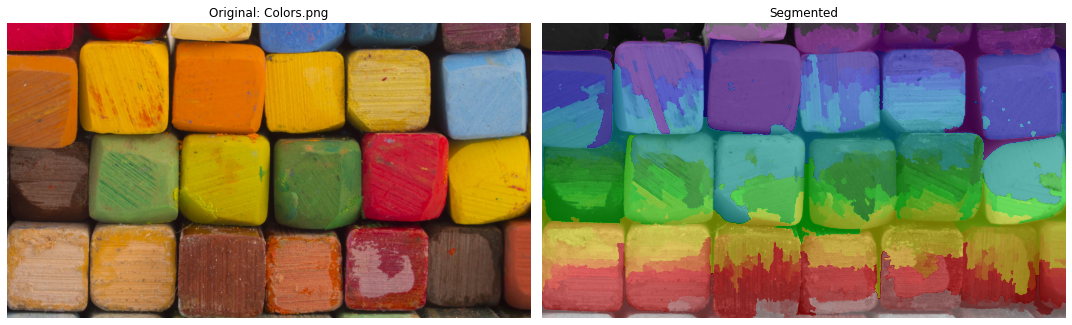

In [ ]:
water_shed('Colors.png')

## Question 3

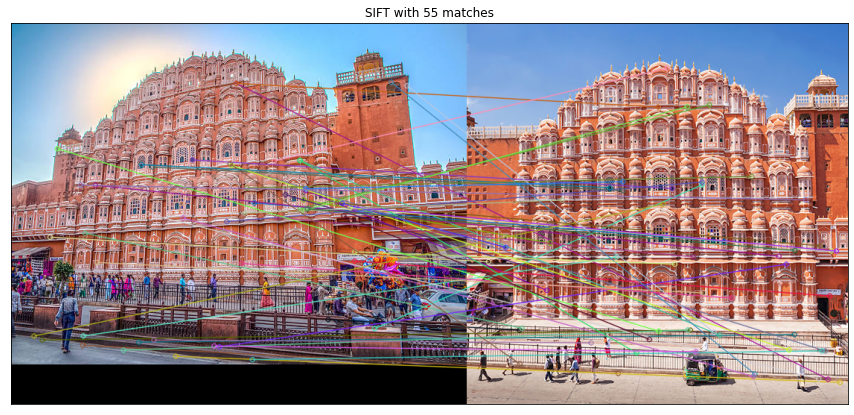

In [ ]:
sift('hawamahal1.jpg', 'hawamahal2.jpg', 55)

In [1]:
def foo(n):
  i=1
  while bar(i)<n:
    i=2*i
  return i

def bar(n):
  if n==0:
    return 1
  x= bar(n//2)
  if n%2==0:
    return x*x
  else:
    return 2*x*x

In [5]:
bar(4)

16